# Classification de phrase

L'objectif de ce notebook est de présenter différentes approches à un problème de classification binaire désequilibré de phrases. Les auteurs des phrases sont Chirac et Mitterrand. Nous allons commencer par jeter un rapide coup d'oeil aux données, puis implémenter un premier modèle simple pour, enfin, 

## 1. Exploraion des données
## 2. Premier modèle simple
## 3. Modèle basé sur un CNN

## 1. Exploration des données

In [2]:
import pickle as pkl
import pandas as pd
import random

Lecture des données

In [3]:
labels = pkl.load(open('./data/train/labels.pkl', 'rb'))
sentences = pkl.load(open('./data/train/sentences.pkl', 'rb'))
sequences = pkl.load(open('./data/train/sequences.pkl', 'rb'))
vocab = pkl.load(open('./data/dict.pkl', 'rb'))

data = pd.DataFrame()
data['sentences'] = sentences
data['sequences'] = sequences
data['labels'] = labels
data.head()

,sentences,sequences,labels
0,J'aurai l'occasion de dire aux Français commen...,"[54, 2187, 5, 320, 1, 102, 47, 74, 357, 33, 64...",C
1,Il est nécessaire.,"[21, 11, 279, 2]",C
2,"Dans votre coeur et dans votre vie, la confian...","[18, 53, 165, 4, 18, 53, 99, 0, 3, 169, 4, 5, ...",C
3,Pour conduire ce débat dans un esprit de vérit...,"[17, 848, 27, 554, 18, 15, 175, 1, 425, 163, 0...",C
4,La France et l'Europe construiront ainsi un av...,"[3, 37, 4, 5, 68, 17747, 146, 15, 111, 1, 195,...",C


In [17]:
print(data[['sentences', 'labels']].groupby('labels').count())
print('Ratio')
ratio = data['labels'].value_counts() / len(data)
print('Chirac:', ratio[0])
print('Mitterand:', ratio[1])

        sentences
labels           
C           39912
M            6018
Ratio
Chirac: 0.8689745264532985
Mitterand: 0.1310254735467015


On observe dans la cellule ci-dessus que le jeu de données est deséquilibré.

In [26]:
# function to generate random sentence pair, one from Chirac, one from Mitterand
def sentences_generator(labels, sentences):
    chirac = random.randint(0, 39912)
    mitterand = random.randint(39912, len(labels))
    print("Chirac: ", sentences[chirac])
    print("Mitterand: ", sentences[mitterand])

Voyons maintenant à quoi ressemblent les phrases:

In [30]:
sentences_generator(labels, sentences)

Chirac:  Son allure, à la fois bienveillante et dynamique, a été conçue spécialement pour Bordeaux, par des Bordelais.
Mitterand:  On ne croit pas, en dépit de ce qui est souvent répété, que cette charte se bornera à de vaines ou de vagues formules.


## 2. Premier modèle simple

Ce modèle est défini par la classe SimpleModel dans le fichier `models.py`. Il s'agit d'un modèle basé sur une couche de word embedding (non pré entraînée) dans lequel les phrases sont les moyennes des mots, ces derniers étant représentés par des vecteurs (voir [ici](https://fr.wikipedia.org/wiki/Word2vec)).

In [1]:
from dataset import TextDataset
from models import SimpleModel
from utils.colors import get_cmap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

/home/nicolas/.local/share/virtualenvs/text_classification-r5fNF6SB/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch: 0
train_loss: 0.3772243781268279
test loss: 0.36761439685886005
model auc: 0.7147494839460687
model mse: 0.10804605290394872
thresholds: [1.76134646e+00 7.61346459e-01 7.58764207e-01 ... 1.39990048e-02
 1.38200903e-02 1.17907289e-03]
sensitivity: [0.00000000e+00 5.60538117e-04 5.60538117e-04 ... 9.99439462e-01
 1.00000000e+00 1.00000000e+00]
specificity: [1.         1.         0.99991664 ... 0.00350117 0.00350117 0.        ]
Epoch: 1
train_loss: 0.3520675159092072
test loss: 0.3412941078123664
model auc: 0.7418907245987826
model mse: 0.10059884122501041
thresholds: [1.87662017e+00 8.76620173e-01 7.82504797e-01 ... 7.15341186e-04
 4.16676980e-04 4.29584215e-05]
sensitivity: [0.00000000e+00 5.60538117e-04 5.60538117e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
specificity: [1.00000000e+00 1.00000000e+00 9.99833278e-01 ... 5.00166722e-04
 3.33444481e-04 0.00000000e+00]
Epoch: 2
train_loss: 0.33722345883992666
test loss: 0.32828060410431403
model auc: 0.7654129057593189
mo

train_loss: 0.15715309753031692
test loss: 0.46217301606328864
model auc: 0.820503368462133
model mse: 0.0933500995204114
thresholds: [2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 2.89184058e-38
 1.91800723e-38 0.00000000e+00]
sensitivity: [0.00000000e+00 5.60538117e-04 1.68161435e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
specificity: [1.         1.         1.         ... 0.00208403 0.00175058 0.        ]


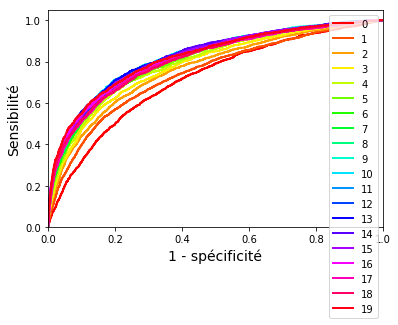

train losses: [0.3772243781268279, 0.3520675159092072, 0.33722345883992666, 0.3246050828904504, 0.31364133137233147, 0.3032302367778122, 0.2924004639795256, 0.2825691666787711, 0.2735148875155984, 0.2625195310216963, 0.25280540058074386, 0.24249185926580483, 0.23142443430003964, 0.2214780559264334, 0.21007913722717195, 0.19830188681407926, 0.18863696655440979, 0.1760011029996077, 0.1674506922781979, 0.15715309753031692]
test losses: [0.36761439685886005, 0.3412941078123664, 0.32828060410431403, 0.32936950135482435, 0.3196193540014269, 0.3130454710752579, 0.30830786130952187, 0.31145572772187236, 0.3096236972206569, 0.33615098630065443, 0.336178913882075, 0.31257983592325167, 0.32699332890882893, 0.35726839324569387, 0.3314258096107793, 0.38984912703616564, 0.38657149163387955, 0.38773098045658944, 0.5118820155235566, 0.46217301606328864]


In [7]:
data = TextDataset(labels, sequences)
data.index_labels()

model = SimpleModel(len(vocab), 10)
if torch.cuda.is_available():
    model.cuda()

train, test = data.split(0.7)

# data loaders
train_loader, test_loader = DataLoader(train, shuffle=True), DataLoader(test, shuffle=True)

# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

num_epoch = 20
train_losses = []
test_losses = []
cmap = get_cmap(num_epoch)

for i in range(num_epoch):
    print("Epoch:", i)
    epoch_loss = 0
    for sequence, label in train_loader:

        # print(sequence)
        # print(label[0])

        sequence = sequence.cuda()
        label = label[0].cuda()

        optimizer.zero_grad()
        prediction = model(sequence)
        output = F.binary_cross_entropy(prediction, label)
        epoch_loss += float(output)
        output.backward()
        optimizer.step()
    print('train_loss:', epoch_loss / len(train_loader.dataset))
    train_losses.append(epoch_loss / len(train_loader.dataset))
    test_loss = 0
    test_labels = []
    test_predictions = []

    # test session
    with torch.no_grad():
        for sequence, label in test_loader:

            test_labels += [float(x) for x in label.cpu().numpy().tolist()[0]]

            sequence = sequence.cuda()
            label = label[0].cuda()

            prediction = model(sequence)

            test_predictions += [float(x) for x in prediction.cpu().numpy()]
            output = F.binary_cross_entropy(prediction, label)
            test_loss += float(output)
        print('test loss:', test_loss / len(test_loader.dataset))
        test_losses.append(test_loss / len(test_loader.dataset))
        # print('test labels:', test_labels)
        # print('test predictions:', test_predictions)

        print('model auc:', roc_auc_score(test_labels, test_predictions))
        print('model mse:', mean_squared_error(test_labels, test_predictions))

        [fpr, tpr, thr] = roc_curve(test_labels, test_predictions)
        print('thresholds:', thr)
        print('sensitivity:', tpr)
        print('specificity:', 1 - fpr)

        plt.plot(fpr, tpr, color=cmap(i), lw=2, label=i)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - spécificité', fontsize=14)
plt.ylabel('Sensibilité', fontsize=14)
plt.legend()
plt.show()

print('train losses:', train_losses)
print('test losses:', test_losses)


Le graphique précédent montre l'évolution de la courbe ROC du modèle. On observe qu'elle s'améliore au fur et à mesure des itérations, jusqu'à environ une quinzaine d'itérations. Le modèle commence alors à overfitter.

### Conclusion

Ce premier modèle fourni une référence sur laquelle se baser afin de proposer des améliorations. Il atteint une AUC (Area Under the Curve: l'aire sous la courbe ROC) maximum de `0.82`. L'avantage de ce modèle est qu'il s'entraîne très rapidement pour une performance correcte.
Pistes d'amélioration:
* Pré entraîner le word embedding avec l'algorithme CBOW par exemple
* Explorer d'autres architectures comme les CNN et les RNN

## 3. Modèle basé sur un CNN

Les CNN (Convolutional Neural Networks) ont fait leurs preuves sur des problèmes de computer vision. Ils fonctionnent en apprenant des filtres adaptés aux données et au problème. Sur du texte, on reprend l'idée du word embedding afin de représenter les mots sous forme de vecteurs. Une phrase est donc une liste de vecteurs, exactement comme une image. Le CNN va construire des filtres en étudiant des groupes de mots de tailles variées.
L'idée vient [d'ici](https://arxiv.org/abs/1408.5882).

In [4]:
from dataset import TorchTextDataset
from train import train


data = TorchTextDataset(sentences, labels)
train_iter, valid_iter = data.get_iterators()

max length: 2528


In [ ]:
from models import CNNModel
import torch


# model parameters
vocab_size = len(data.text_field.vocab)
embeddings_size = 64
kernel_sizes = [2, 4, 8, 16]
kernel_num = 10
dropout = 0.5

# training parameters
num_epoch = 10
lr = 1e-3
cuda = torch.cuda.is_available()
log_interval = 100
valid_interval = 100

model = CNNModel(vocab_size, embeddings_size, kernel_sizes, kernel_num, dropout)

train_losses, train_auc, valid_losses, valid_auc = train(model, train_iter, valid_iter, num_epoch, lr, cuda, log_interval, valid_interval)


In [ ]:
x = range(len(train_losses))

plt.plot(train_losses, x, label='training loss')
plt.plot(train_auc, x, label='training auc')
plt.plot(valid_losses, x, label='validation loss')
plt.plot(valid_auc, x, label='validation auc')

plt.legend()
plt.show

### Conclusion

Ce modèle est beaucoup plus complexe, ce qui implique un entraînement plus compliqué, à la fois en terme de temps ainsi qu'en terme d'ajustement des paramètres.
Pistes d'amélioration:
* Pré-entraîner le word embedding
* Essayer une architecture avec des RNN